# AI09 - Devoir 1 : Pont électrique et Monte Carlo
### Hugo Le Moine

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Donner une simulation des états de cinq composants et en fonction de ces états déﬁnir l’état du pont (1 ou 0).

In [59]:
# parameters for simulation
p = .99
q = 1 - p
n_simulations = 1000
n_composants = 5

In [60]:
# Generating data for n_composants and n_simulations with failure probability of q
df = pd.DataFrame(
    data = np.where(np.random.random(size=(n_simulations, n_composants)) > q, 1, 0),
    columns = [f'composant_{i+1}' for i in range(n_composants)])

In [61]:
# statistics summary of generated data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
composant_1,1000.0,0.985,0.121613,0.0,1.0,1.0,1.0,1.0
composant_2,1000.0,0.993,0.083414,0.0,1.0,1.0,1.0,1.0
composant_3,1000.0,0.991,0.094488,0.0,1.0,1.0,1.0,1.0
composant_4,1000.0,0.989,0.104355,0.0,1.0,1.0,1.0,1.0
composant_5,1000.0,0.993,0.083414,0.0,1.0,1.0,1.0,1.0


In [62]:
df.apply(pd.value_counts)

,composant_1,composant_2,composant_3,composant_4,composant_5
1,985,993,991,989,993
0,15,7,9,11,7


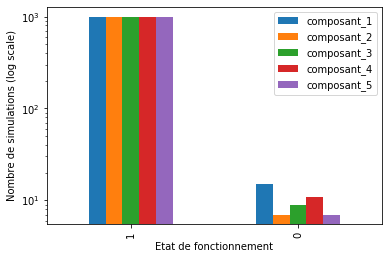

In [63]:
# Visualization of generated data
df.apply(pd.value_counts).plot.bar()
plt.xlabel('Etat de fonctionnement')
plt.ylabel('Nombre de simulations (log scale)')
plt.yscale('log')

## 2. Estimer la probabilité de bon fonctionnement du pont, se basant sur 1000 simulations.

Le pont fonctionne si tous les composants d'au moins un des chemins suivants fonctionnent:
- 1-4
- 2-5
- 1-3-5
- 2-3-4

On utilise les données générées à la question 1 pour simuler l'état de fonctionnement du pont

In [64]:
def is_bridge_working(df):
    """
    Returns 1 if the bridge is working according to problem schema.
    """
    if df.composant_1 & df.composant_4:
        return 1
    elif df.composant_2 & df.composant_5:
        return 1
    elif df.composant_1 & df.composant_3 & df.composant_5:
        return 1
    elif df.composant_2 & df.composant_3 & df.composant_4:
        return 1
    else:
        return 0

In [65]:
# bridge column takes value 1 if working, else 0.
df['bridge'] = df.apply(is_bridge_working, axis=1)

In [66]:
# counting values in bridge column
df.bridge.value_counts()

1    1000
Name: bridge, dtype: int64

On constate qu'avec 1000 simulations, aucune n'a conduit a un état de panne du pont.

## 3. Si l’erreur admise pour ce résultat est $ \epsilon = 10^{-2}$ et $\theta = 5.10^{-2}$, alors donner le nombre de tirages nécessaires pour obtenir cette précision. Exécutez la simulation

Afin de calculer le nombre de tirages nécessaires, il faut d'abord estimer et borner la variance

In [67]:
df.bridge.var()

0.0

La variance empirique actuellement calculée étant nulle, on réalise un nouvelle simulation avec n plus grand : 100 000

In [72]:
# parameters for simulation
p = .99
q = 1 - p
n_simulations = 100000
n_composants = 5

# Generating data for n_composants and n_simulations with failure probability of q
df = pd.DataFrame(
    data = np.where(np.random.random(size=(n_simulations, n_composants)) > q, 1, 0),
    columns = [f'composant_{i+1}' for i in range(n_composants)])

# bridge column takes value 1 if working, else 0.
df['bridge'] = df.apply(is_bridge_working, axis=1)

# counting values in bridge column
df.bridge.value_counts()

1    99980
0       20
Name: bridge, dtype: int64

In [73]:
variance = df.bridge.var()
print(f'Variance = {variance:.3e}')

Variance = 2.000e-04


On peut borner $Var(h(X)) \leq C$ avec $C = 5.10^{-4}$

On a ainsi : 
$$n \geq \frac{C}{\theta\epsilon^2} \\
n \geq \frac{5.10^{-4}}{(10^{-2})^2*5*10^{-2}} \\
n \geq 100
$$

In [74]:
# parameters for simulation
p = .99
q = 1 - p
n_simulations = 100
n_composants = 5

# Generating data for n_composants and n_simulations with failure probability of p
df = pd.DataFrame(
    data = np.where(np.random.random(size=(n_simulations, n_composants)) > q, 1, 0),
    columns = [f'composant_{i+1}' for i in range(n_composants)])

# bridge column takes value 1 if working, else 0.
df['bridge'] = df.apply(is_bridge_working, axis=1)

# counting values in bridge column
df.bridge.value_counts()

1    100
Name: bridge, dtype: int64

On constate à nouveau qu'aucune simulation ne conduit à un état de panne du pont. Néanmoins, cela correspond à la préccision recherchée dans l'énoncé.

## 4. Maintenant nous changeons de loi, et au lieu de la valeur précédente $q$, nous prenons $q\prime = \frac{q}{pe^t+q}$, avec une constante t, à ﬁxer dans l’intervalle $[2\ln \frac{1+\sqrt{1−4pq}}{2p} ,+\infty[$. Alors expliquez pourquoi ce choix est meilleur. Estimer de nouveau la probabilité de bon fonctionnement du pont avec cette nouvelle loi

Afin de comprendre l'impact du paramètre t, affichons d'abord l'évolution de q' en fonction de t.

In [75]:
# parameters for simulation
p = .99
q = 1 - p

In [76]:
# Generating q' for several values of t
t_min = 2*np.log((2 * np.sqrt(1 - 4*q*p)) / (2*p))
t = np.linspace(t_min, 10, 100)
q_prime = q / (p * np.exp(t) + q)

Text(0, 0.5, "q'")

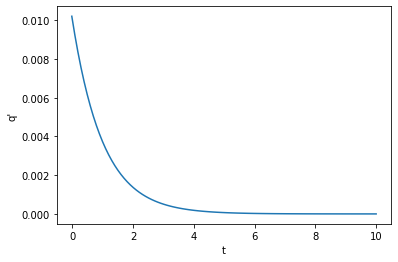

In [77]:
# Visualization of q' depending on t
plt.plot(t, q_prime)
plt.xlabel('t')
plt.ylabel('q\'')

On constate que plus t est grand, plus q' est petit, et donc qu'un état de panne du système est moins probable.
Pour la suite, choisissons arbitrairement $t=2$ et effectuons 100 000 simulations

In [85]:
# parameters for simulation
p = .99
q = 1 - p
t = 2
q_prime = q / (p * np.exp(t) + q)
n_simulations = 100000
n_composants = 5

In [86]:
# Generating data for n_composants and n_simulations with failure probability of p
df = pd.DataFrame(
    data = np.where(np.random.random(size=(n_simulations, n_composants)) > q_prime, 1, 0),
    columns = [f'composant_{i+1}' for i in range(n_composants)])

# bridge column takes value 1 if working, else 0.
df['bridge'] = df.apply(is_bridge_working, axis=1)

# counting values in bridge column
df.bridge.value_counts()

1    100000
Name: bridge, dtype: int64

Aucune des 100 000 simulations n'a conduit à un état de panne. La variance reste donc de 0. Testons maintenant avec 1 million de simulations.

In [87]:
n_simulations = int(1e6)

# Generating data for n_composants and n_simulations with failure probability of p
df = pd.DataFrame(
    data = np.where(np.random.random(size=(n_simulations, n_composants)) > q_prime, 1, 0),
    columns = [f'composant_{i+1}' for i in range(n_composants)])

# bridge column takes value 1 if working, else 0.
df['bridge'] = df.apply(is_bridge_working, axis=1)

# counting values in bridge column
df.bridge.value_counts()

1    999998
0         2
Name: bridge, dtype: int64

In [88]:
variance = df.bridge.var()
print(f'Variance = {variance:.4e}')

Variance = 2.0000e-06


Maintenant que nous obtenons une variance non nulle, on peut estimer le nombre de simulations $n$ nécessaire pour satisfaire la contrainte de précision donnée à la question précédente

On peut borner $Var(h(X)) \leq C$ avec $C = 5.10^{-6}$

On a ainsi : 
$$n \geq \frac{C}{\theta\epsilon^2} \\
n \geq \frac{5.10^{-6}}{(10^{-2})^2*5*10^{-2}} \\
n \geq 1
$$

Finalement, cette nouvelle loi permet d'obtenir une variance bien plus faible (4 ordres de grandeur). Ce résultat est cohérent puisque la probabilité d'une panne du pont se trouvera grandement réduite avec la diminution de q' (induite par l'augmentation de $t$). Pour obtenir une même précision, il suffira d'une seule simulation contre 100 avec la première loi utilisée.